In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.sandbox.stats.multicomp import multipletests
import numpy as np
data_root = '/Users/haileytrier/Downloads/Trier_et_al_2023_code/data/'

In [18]:
def TTestsOrWilcoxon(plotdf, regname):
    '''
    Compute one-sided single sample t-tests or wilcoxon tests for each bar in the chart.
    Pass in the dataframe used for plotting and the name of the regressor it describes.
    '''
    pd.set_option('display.float_format', lambda x: f'{x:.10f}')
    statsdf = pd.DataFrame(columns=["ROI","Phase","NormalDist","T_stat","wilcox_stat","P_val","TestType","Tail","Mean"])
    
    for r in rois:
        # Two-sided test for pre-disc. phase
        vals = plotdf.loc[(plotdf.ROI==r) & (plotdf.Phase=='Pre'),'Value'].values
        if stats.normaltest(vals).pvalue >= 0.05: # is normally distributed
            normaldist = 'True'
            testtype = "t-test (2-sided)"
            [tstat, pval_pre] = stats.ttest_1samp(vals, 0, alternative='two-sided')
            wstat, ztat = np.nan, np.nan
        else:
            normaldist = 'False'
            testtype = "wilcoxon (2-sided)"
            tstat = np.nan
            pval_pre = np.nan
            [wstat, pval_pre] = stats.wilcoxon(vals, alternative='two-sided')

        temp = pd.DataFrame(data={"ROI":[r],
                              "Phase":['Pre'],
                              "NormalDist":[normaldist],
                              "T_stat":[tstat],
                              "P_val":[pval_pre],
                              "wilcox_stat":[wstat],
                              "TestType":[testtype],
                              "Tail":[np.nan],
                              "Mean":[np.mean(vals)]})

        statsdf = pd.concat([statsdf, temp])
        del temp, tstat, vals, normaldist, wstat, testtype
        
        if pval_pre < 0.05: # do replication test if pre-disc. phase was significant
            tail = 'greater' if np.mean(plotdf.loc[(plotdf.ROI==r) & (plotdf.Phase=='Pre'),'Value'].values)>0 else 'less'
            vals = plotdf.loc[(plotdf.ROI==r) & (plotdf.Phase=='Post'),'Value'].values
            if stats.normaltest(vals).pvalue >= 0.05: # is normally distributed
                normaldist = 'True'
                testtype = "t-test (1-sided)"
                [tstat, pval_post] = stats.ttest_1samp(vals, 0, alternative=tail)
                wstat, ztat = np.nan, np.nan
            else:
                normaldist = 'False'
                testtype = "wilcoxon (1-sided)"
                tstat = np.nan
                pval_post = np.nan
                [wstat, pval_post] = stats.wilcoxon(vals, alternative=tail)

            temp = pd.DataFrame(data={"ROI":[r],
                                  "Phase":['Post'],
                                  "NormalDist":[normaldist],
                                  "T_stat":[tstat],
                                  "P_val":[pval_post],
                                  "wilcox_stat":[wstat],
                                  "TestType":[testtype],
                                  "Tail":[tail],
                                  "Mean":[np.mean(vals)]})

            statsdf = pd.concat([statsdf, temp])
            del temp, tstat, pval_post, vals, normaldist, pval_pre
        else:
            temp = pd.DataFrame(data={"ROI":[r],
                      "Phase":['Post'],
                      "NormalDist":[np.nan],
                      "T_stat":[np.nan],
                      "P_val":[np.nan],
                      "wilcox_stat":[np.nan],
                      "TestType":[np.nan],
                      "Tail":[np.nan],
                      "Mean":[np.nan]})

            statsdf = pd.concat([statsdf, temp])

    statsdf['Regressor'] = regname
    return statsdf

def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue < 0.05:
        return "*"
    elif pvalue >= 0.05:
        return "n.s."
    else:
        return " "

### Plot ROI statistics

In [6]:
# Read in ROI statistics at the individual level across all participants and actions.
df_org = pd.read_csv('/Users/haileytrier/Downloads/Trier_et_al_2023_code/Figure_2/data/ROI_stats_all_participants.csv',index_col=0)
df_org.head()

,ParticipantID,ROI,NCope,Phase,Action,Regressor,Value
0,sub103,DRN,1,post,firstCheck,Constant,0.2298
1,sub103,DRN,2,post,firstCheck,TimeSinceLastCheck,0.3826
2,sub103,DRN,3,post,firstCheck,Proximity,0.2873
3,sub103,DRN,4,post,firstCheck,Reward,0.8362
4,sub103,DRN,5,post,firstForage,Constant,0.3000


In [7]:
df_org['Regname'] = [df_org.loc[x,'Action'] + df_org.loc[x,'Regressor'] for x in range(len(df_org))]
df_org['ROI'] = df_org['ROI'].str.replace('HB','Hb')

fontscale = 2

/var/folders/ck/bj1v04rj5k97nqvzmysnm2wr0000gn/T/ipykernel_69319/3321101566.py:26: FutureWarning: 

The `errcolor` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'color': 'black'}` instead.

  ax = sns.barplot(
/var/folders/ck/bj1v04rj5k97nqvzmysnm2wr0000gn/T/ipykernel_69319/3321101566.py:26: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.5}` instead.

  ax = sns.barplot(
/var/folders/ck/bj1v04rj5k97nqvzmysnm2wr0000gn/T/ipykernel_69319/3321101566.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(rois, rotation = 45, ha="right")


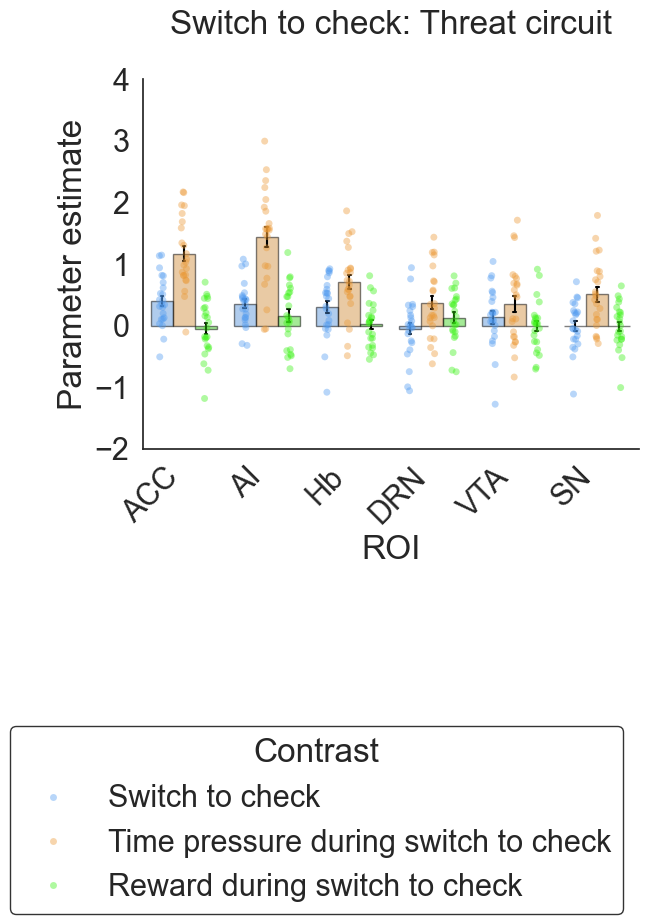

In [10]:
# Fig. 2D: Switch to check: Threat circuit activity
phase = 'pre'
rois = ['ACC','AI','Hb','DRN','VTA','SN']
if phase == 'pre':
    regs = ['firstCheckConstant','firstCheckTimePressure','firstCheckReward']
elif phase == 'post':
    regs = ['firstCheckConstant','firstCheckProximity']
    
inds = [x for x in range(len(df_org)) if df_org.loc[x,'ROI'] in rois and df_org.loc[x,'Phase']==phase and df_org.loc[x,'Regname'] in regs]
plotdf = df_org.loc[inds,:]

# Replace contrasts with nice labels
plotdf['Regname'] = plotdf['Regname'].replace({'firstCheckConstant':'Switch to check',
                                                   'firstCheckTimePressure':'Time pressure during switch to check',
#                                                    'firstCheckProximity':'Proximity during switch to check',
                                                   'firstCheckReward':'Reward during switch to check'})
plotdf['Regname'] = pd.Categorical(plotdf['Regname'],categories=['Time pressure during switch to check',
                                                                 'Switch to check','Reward during switch to check'])

colors = {'Time pressure during switch to check': "#eb9834", # orange
          'Switch to check': "#4f9af0", # blue
         'Reward during switch to check':'#39f213'} # green
hue_order = ['Switch to check','Time pressure during switch to check','Reward during switch to check']
sns.set(font_scale=fontscale)
sns.set_style("white")
ax = sns.barplot(
    x="ROI", 
    y="Value", 
    hue="Regname", 
    data=plotdf, 
    errorbar=("ci",68), 
    edgecolor="black",
    errcolor="black",
    errwidth=1.5,
    palette=colors,#"colorblind",
    capsize = 0.1,
    alpha=0.5, order=rois,hue_order=hue_order)
sns.despine()
sns.stripplot(
    x="ROI", 
    y="Value", 
    hue="Regname", 
    data=plotdf, dodge=True, alpha=0.4, ax=ax, 
    order=rois,palette=colors,hue_order=hue_order
)
plt.title('Switch to check: Threat circuit', y=1.1)

handles, labels = ax.get_legend_handles_labels()
ax.set(xlabel='ROI', ylabel='Parameter estimate')
ax.set_xticklabels(rois, rotation = 45, ha="right")
yrange = [-2,4]
ax.set(ylim=yrange)
ax.legend(handles[3:], labels[3:], title='Contrast', bbox_to_anchor=(1, -1.3), loc='lower right', edgecolor="black")

/var/folders/ck/bj1v04rj5k97nqvzmysnm2wr0000gn/T/ipykernel_69319/1536210014.py:22: FutureWarning: 

The `errcolor` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'color': 'black'}` instead.

  ax = sns.barplot(
/var/folders/ck/bj1v04rj5k97nqvzmysnm2wr0000gn/T/ipykernel_69319/1536210014.py:22: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.5}` instead.

  ax = sns.barplot(
/var/folders/ck/bj1v04rj5k97nqvzmysnm2wr0000gn/T/ipykernel_69319/1536210014.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(rois, rotation = 45, ha="right")


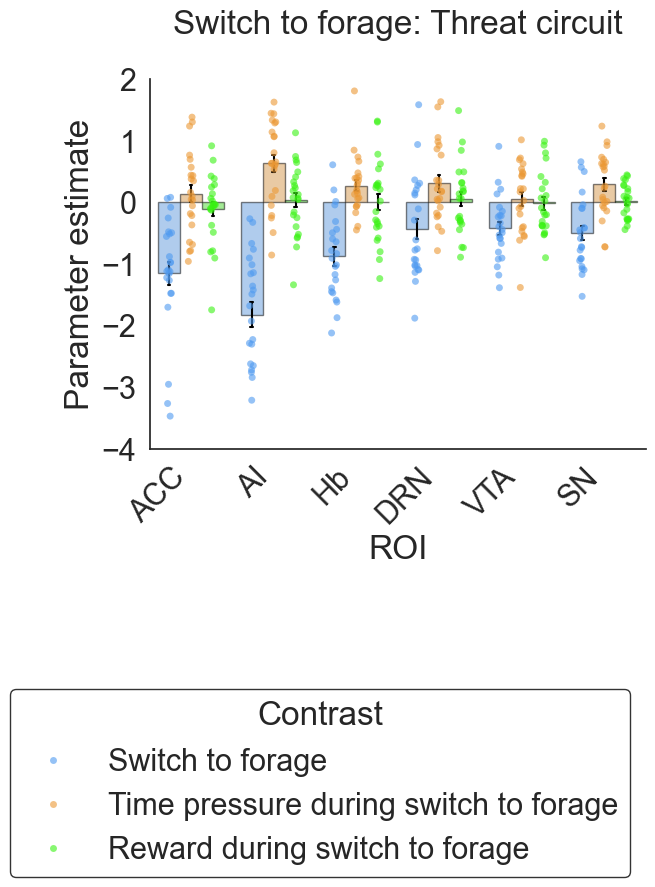

In [11]:
# Fig. 2E: Switch to forage: Threat circuit activity
phase = 'pre'
rois = ['ACC','AI','Hb','DRN','VTA','SN']
regs = ['firstForageConstant','firstForageReward','firstForageTimePressure']
inds = [x for x in range(len(df_org)) if df_org.loc[x,'ROI'] in rois and df_org.loc[x,'Phase']==phase and df_org.loc[x,'Regname'] in regs]
plotdf = df_org.loc[inds,:]

# Replace contrasts with nice labels
plotdf['Regname'] = plotdf['Regname'].replace({'firstForageConstant':'Switch to forage',
                                                   'firstForageReward':'Reward during switch to forage',
                                              'firstForageTimePressure':'Time pressure during switch to forage'})
plotdf['Regname'] = pd.Categorical(plotdf['Regname'],categories=['Reward during switch to forage',
                                                                 'Switch to forage',
                                                                'Time pressure during switch to forage'])

colors = {'Time pressure during switch to forage': "#eb9834", # orange
          'Switch to forage': "#4f9af0", # blue
         'Reward during switch to forage':'#39f213'} # green
hue_order = ['Switch to forage','Time pressure during switch to forage','Reward during switch to forage']
sns.set(font_scale=fontscale)
sns.set_style("white")
ax = sns.barplot(
    x="ROI", 
    y="Value", 
    hue="Regname", 
    data=plotdf, 
    errorbar=("ci",68), 
    edgecolor="black",
    errcolor="black",
    errwidth=1.5,
    palette=colors,
    capsize = 0.1,
    alpha=0.5, order=rois, hue_order=hue_order)
sns.despine()
sns.stripplot(
    x="ROI", 
    y="Value", 
    hue="Regname", 
    data=plotdf, dodge=True, alpha=0.6, ax=ax, 
    order=rois,palette=colors, hue_order=hue_order
)

# remove extra legend handles
plt.title('Switch to forage: Threat circuit', y=1.1)
handles, labels = ax.get_legend_handles_labels()
ax.set(xlabel='ROI', ylabel='Parameter estimate')
ax.set_xticklabels(rois, rotation = 45, ha="right")
yrange = [-4,2]
ax.set(ylim=yrange)
ax.legend(handles[3:], labels[3:], title='Contrast', bbox_to_anchor=(1, -1.2), loc='lower right', edgecolor="black")

/var/folders/ck/bj1v04rj5k97nqvzmysnm2wr0000gn/T/ipykernel_69319/713984467.py:22: FutureWarning: 

The `errcolor` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'color': 'black'}` instead.

  ax = sns.barplot(
/var/folders/ck/bj1v04rj5k97nqvzmysnm2wr0000gn/T/ipykernel_69319/713984467.py:22: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.5}` instead.

  ax = sns.barplot(
/var/folders/ck/bj1v04rj5k97nqvzmysnm2wr0000gn/T/ipykernel_69319/713984467.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(rois, rotation = 45, ha="right")


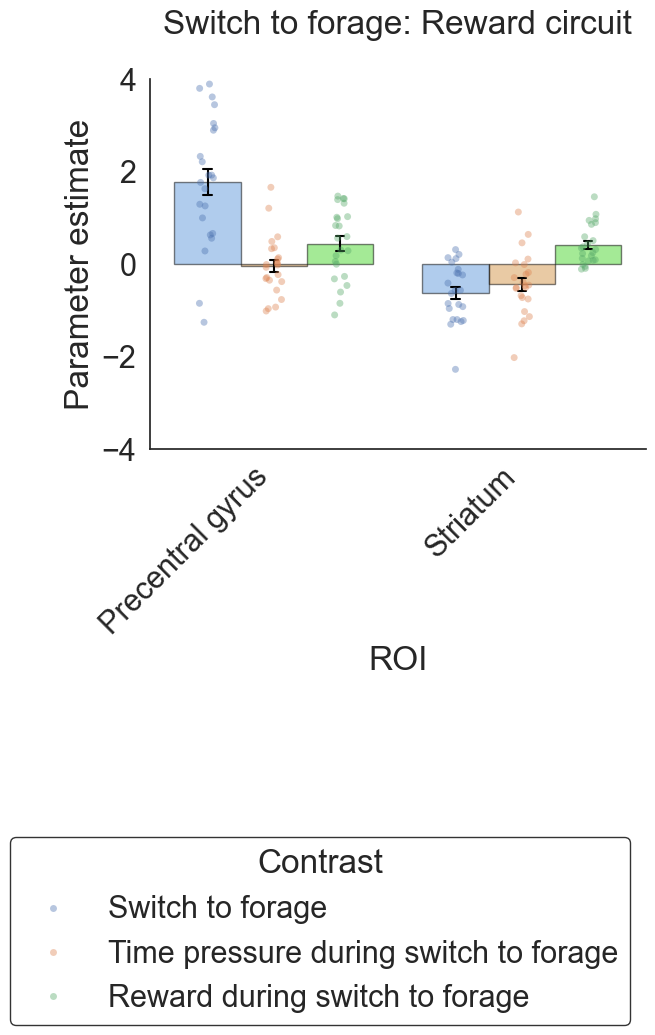

In [12]:
# Fig. 6C: Switch to forage: Reward circuit activity
phase = 'pre'
rois = ['Precentral gyrus','Striatum'] #'ACC','DRN'
regs = ['firstForageConstant','firstForageReward','firstForageTimePressure']
inds = [x for x in range(len(df_org)) if df_org.loc[x,'ROI'] in rois and df_org.loc[x,'Phase']==phase and df_org.loc[x,'Regname'] in regs]
plotdf = df_org.loc[inds,:]

# Replace contrasts with nice labels
plotdf['Regname'] = plotdf['Regname'].replace({'firstForageConstant':'Switch to forage',
                                              'firstForageReward':'Reward during switch to forage',
                                              'firstForageTimePressure':'Time pressure during switch to forage'})
plotdf['Regname'] = pd.Categorical(plotdf['Regname'],categories=['Reward during switch to forage',
                                                                 'Switch to forage',
                                                                 'Time pressure during switch to forage'])

colors = {'Time pressure during switch to forage': "#eb9834", # orange
          'Switch to forage': "#4f9af0", # blue
         'Reward during switch to forage':'#39f213'} # green
hue_order = ['Switch to forage','Time pressure during switch to forage','Reward during switch to forage']
sns.set(font_scale=fontscale)
sns.set_style("white")
ax = sns.barplot(
    x="ROI", 
    y="Value", 
    hue="Regname", 
    data=plotdf, 
    errorbar=("ci",68), 
    edgecolor="black",
    errcolor="black",
    errwidth=1.5,
    palette=colors,
    capsize = 0.1,
    alpha=0.5, order=rois,hue_order=hue_order)
sns.set_style("white")
sns.despine()
sns.stripplot(
    x="ROI", 
    y="Value", 
    hue="Regname", 
    data=plotdf, dodge=True, alpha=0.4, ax=ax, 
    order=rois,hue_order=hue_order
)
plt.title('Switch to forage: Reward circuit', y=1.1)

# remove extra legend handles
handles, labels = ax.get_legend_handles_labels()
ax.set(xlabel='ROI', ylabel='Parameter estimate')
ax.set_xticklabels(rois, rotation = 45, ha="right")
yrange = [-4,4]
ax.set(ylim=yrange)
ax.legend(handles[3:], labels[3:], title='Contrast', bbox_to_anchor=(1, -1.6), loc='lower right', edgecolor="black")

/var/folders/ck/bj1v04rj5k97nqvzmysnm2wr0000gn/T/ipykernel_69319/147585197.py:27: FutureWarning: 

The `errcolor` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'color': 'black'}` instead.

  ax = sns.barplot(
/var/folders/ck/bj1v04rj5k97nqvzmysnm2wr0000gn/T/ipykernel_69319/147585197.py:27: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.5}` instead.

  ax = sns.barplot(
/var/folders/ck/bj1v04rj5k97nqvzmysnm2wr0000gn/T/ipykernel_69319/147585197.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(rois, rotation = 45, ha="right")


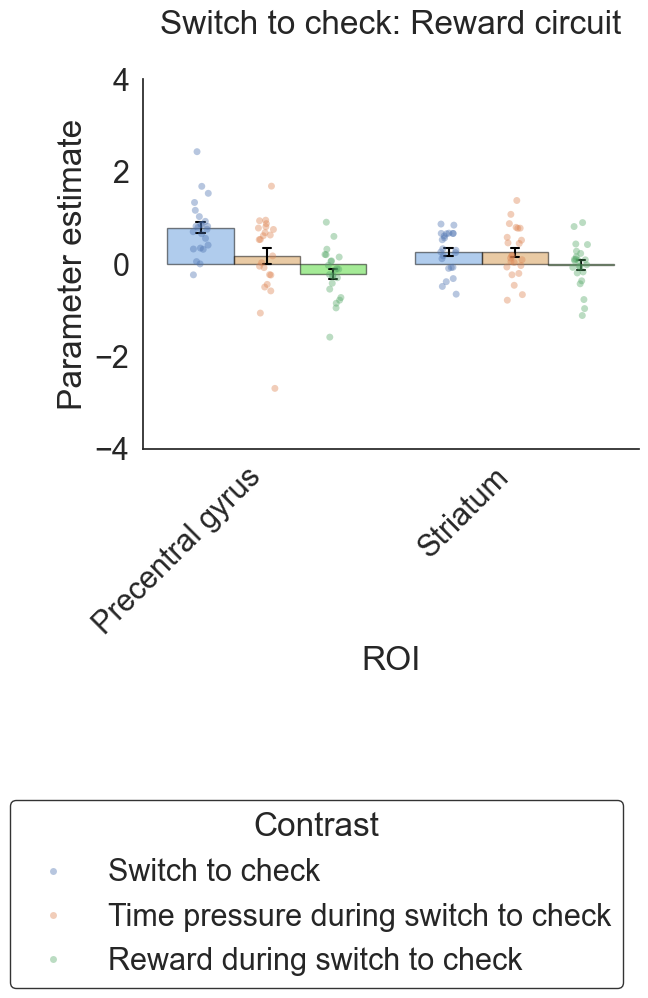

In [14]:
# Fig. 6D: Switch to check: Reward circuit activity
phase = 'pre'
rois = ['Precentral gyrus','Striatum'] #'ACC','DRN'
if phase == 'pre':
    regs = ['firstCheckConstant','firstCheckTimePressure','firstCheckReward']
elif phase == 'post':
    regs = ['firstCheckConstant','firstCheckProximity']
    
inds = [x for x in range(len(df_org)) if df_org.loc[x,'ROI'] in rois and df_org.loc[x,'Phase']==phase and df_org.loc[x,'Regname'] in regs]
plotdf = df_org.loc[inds,:]

# Replace contrasts with nice labels
plotdf['Regname'] = plotdf['Regname'].replace({'firstCheckConstant':'Switch to check',
                                              'firstCheckTimePressure':'Time pressure during switch to check',
#                                               'firstCheckProximity':'Proximity during switch to check',
                                              'firstCheckReward':'Reward during switch to check'})
plotdf['Regname'] = pd.Categorical(plotdf['Regname'],categories=['Time pressure during switch to check',
                                                                 'Switch to check',
                                                                'Reward during switch to check'])

colors = {'Time pressure during switch to check': "#eb9834", # orange
          'Switch to check': "#4f9af0", # blue
         'Reward during switch to check':'#39f213'} # green
hue_order = ['Switch to check','Time pressure during switch to check','Reward during switch to check']
sns.set(font_scale=fontscale)
sns.set_style("white")
ax = sns.barplot(
    x="ROI", 
    y="Value", 
    hue="Regname", 
    data=plotdf, 
    errorbar=("ci",68), 
    edgecolor="black",
    errcolor="black",
    errwidth=1.5,
    palette=colors,
    capsize = 0.1,
    alpha=0.5, order=rois,hue_order=hue_order)
sns.despine()
sns.stripplot(
    x="ROI", 
    y="Value", 
    hue="Regname", 
    data=plotdf, dodge=True, alpha=0.4, ax=ax, 
    order=rois,hue_order=hue_order
)
plt.title('Switch to check: Reward circuit', y=1.1)

# remove extra legend handles
handles, labels = ax.get_legend_handles_labels()
ax.set(xlabel='ROI', ylabel='Parameter estimate')
ax.set_xticklabels(rois, rotation = 45, ha="right")
yrange = [-4,4]
ax.set(ylim=yrange)
ax.legend(handles[3:], labels[3:], title='Contrast', bbox_to_anchor=(1, -1.5), loc='lower right', edgecolor="black")

In [21]:
all_stats = all_stats.reset_index(drop=True)
all_stats

,ROI,Phase,NormalDist,T_stat,wilcox_stat,P_val,TestType,Tail,Mean,Regressor
0,ACC,Pre,True,4.6446561746,NaN,0.0001249671,t-test (2-sided),NaN,0.3974782609,Switch to check
1,AI,Pre,True,4.6853511029,NaN,0.0001131655,t-test (2-sided),NaN,0.3527304348,Switch to check
2,Hb,Pre,False,NaN,48.0000000000,0.0048513412,wilcoxon (2-sided),NaN,0.3100000000,Switch to check
3,DRN,Pre,True,-0.4873684528,NaN,0.6308183641,t-test (2-sided),NaN,-0.0486217391,Switch to check
4,VTA,Pre,False,NaN,81.0000000000,0.0858278275,wilcoxon (2-sided),NaN,0.1380652174,Switch to check
5,SN,Pre,True,-0.0188487120,NaN,0.9851316975,t-test (2-sided),NaN,-0.0015478261,Switch to check
6,ACC,Post,True,4.7517998390,NaN,0.0001083128,t-test (1-sided),greater,0.8654058824,Switch to check
7,AI,Post,True,8.5023866536,NaN,0.0000001247,t-test (1-sided),greater,1.5838176471,Switch to check
8,Hb,Post,True,4.9954681289,NaN,0.0000660348,t-test (1-sided),greater,0.7129470588,Switch to check
9,DRN,Post,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Switch to check
